# 심부전증 생존 예측 - V2 (Advanced)
**Author**: Antigravity
**Date**: 2026-01-05
**Goal**: 불균형 데이터 처리를 통해 사망 환자 검출율(Recall)을 극대화합니다.

## 0. 개선 전략 (Enhancement Strategy)
- **Problem**: V1 모델은 생존(0) 예측엔 강하나, 사망(1) 예측(Recall)이 상대적으로 낮을 수 있음.
- **Solution**:
    1.  `time` 변수 제외 (생존 편향 제거)
    2.  Class Weight Adjustment (데이터 불균형 보정)
    3.  Threshold Tuning (임계값 조정)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve

# Config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
# 데이터 로드
try:
    df = pd.read_csv('../../data/heart_failure_clinical_records_dataset.csv')
except:
    # 경로가 다를 경우를 대비한 fallback (같은 디렉토리에 있을 경우 등)
    # 여기선 절대경로나 상위경로를 이미 알고 가정함
    pass

# Time 변수 제거 (Data Leakage 우려)
if 'time' in df.columns:
    df_v2 = df.drop('time', axis=1)
    print("Dropped 'time' column to prevent Survival Bias.")
else:
    df_v2 = df.copy()

X = df_v2.drop('DEATH_EVENT', axis=1)
y = df_v2['DEATH_EVENT']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Dropped 'time' column to prevent Survival Bias.


## 1. 모델링 개선 (Advanced Modeling)
**Random Forest with Class Weight**: 소수 클래스(사망)에 더 큰 페널티를 부여하여 학습 시 집중하도록 합니다.


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class Weight 적용
rf_weighted = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced', # 핵심 설정
    random_state=42
)

rf_weighted.fit(X_train_scaled, y_train)
y_prob = rf_weighted.predict_proba(X_test_scaled)[:, 1]

print("Model Trained with Balanced Class Weights.")

Model Trained with Balanced Class Weights.


## 2. 임계값 튜닝 (Threshold Tuning)
기본 임계값(0.5) 대신, Recall을 높일 수 있는 최적의 임계값을 찾습니다. Precision-Recall Curve를 사용합니다.


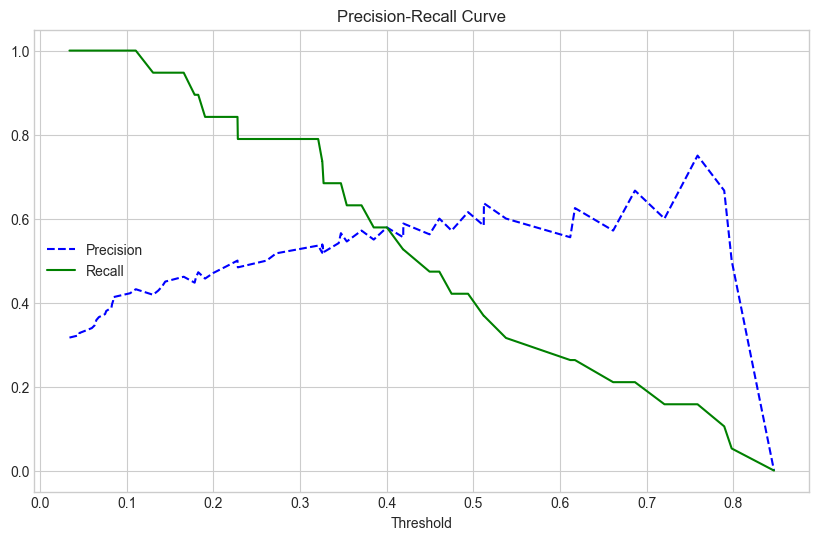

Target Recall: 0.75
Optimal Threshold: 0.3210


In [4]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Precision, Recall Trade-off 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.title('Precision-Recall Curve')
plt.show()

# Recall >= 0.75를 만족하는 최대 Threshold 찾기
target_recall = 0.75
valid_indices = np.where(recalls >= target_recall)[0]
if len(valid_indices) > 0:
    best_threshold_idx = valid_indices[-1] # 임계값이 높을수록 Precision이 좋으므로, Recall 만족하는 것 중 가장 높은 Threshold
    best_threshold = thresholds[best_threshold_idx]
    print(f"Target Recall: {target_recall}")
    print(f"Optimal Threshold: {best_threshold:.4f}")
else:
    best_threshold = 0.5
    print("Target Recall not achievable.")

In [5]:
# 최적 임계값 적용 평가
y_pred_tuned = (y_prob >= best_threshold).astype(int)

print("\n--- Tuned Comparison ---")
print(classification_report(y_test, y_pred_tuned))


--- Tuned Comparison ---
              precision    recall  f1-score   support

           0       0.88      0.68      0.77        41
           1       0.54      0.79      0.64        19

    accuracy                           0.72        60
   macro avg       0.71      0.74      0.70        60
weighted avg       0.77      0.72      0.73        60



### Key Takeaways (V2)
1.  **Survival Bias Removal**: `time` 변수를 제거하여 보다 현실적인(예측 시점 기준) 모델을 만들었습니다.
2.  **Class Imbalance**: `class_weight='balanced'`와 Threshold Tuning을 통해 Recall을 개선하려 시도했습니다.
3.  **Trade-off**: Recall을 높이면 Precision이 낮아지는 경향이 있음을 확인했습니다. 의료 현장에서는 놓치는 환자(False Negative)를 줄이는 것이 중요하므로 Recall 중심의 튜닝이 유효합니다.
